# **Personal Information**
- Class: Programming for Data Science - 23KHDL
- Full name: Trầm Hữu Nhân
- ID: 23127442

## Librabries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath('..'))

from src.models import *

## Setup


In [2]:
%reload_ext autoreload
%autoreload 2

X = np.load('../data/processed/X_train.npy')
y = np.load('../data/processed/y_train.npy')

## Train - Test Splitting
I will run my machine learning model on the following dataset:
- **80%** of the samples will be taken out for learning
- **20%** of the samples will be taken out to test the learning process before running it on the test set

In [3]:
X_train, X_test, y_train, y_test = train_test_split_numpy(X, y, test_size=0.2, random_state=42)

## Machine Learning Model
I choose **Logistic Regression** model, because:
- **Interpretability**: 
    - This is the most important requirement of the HR problem. We need to know not only who is leaving, but why.
    - Through the set of weights ($w$), Logistic Regression allows quantifying the impact: A large positive weight means that the factor promotes turnover, a negative weight means that the factor helps retain employees.

- **Probabilistic Output**:
    - Logistic Regression returns probabilities ($0 \le P \le 1$).
    - This is extremely useful for dealing with imbalanced data. We can flexibly adjust the `Threshold` to find talent at risk of leaving.
- **High-dimensional & Sparse Data**:
    - After **One-Hot Encoding**, the feature matrix will expand to many columns and contain many zeros. Logistic Regression handles this type of matrix very quickly and efficiently.
    

## Implementation Strategy
- **Activation Function**:
    - Sigmoid function $\sigma(z) = \frac{1}{1 + e^{-z}}$.
    - Compressing linear calculation results ($z = wX+b$) which can approach infinity to the interval $(0, 1)$ to represent probability.-  - Use `np.exp` combined with `np.clip` to ensure arithmetic stability, avoiding overflow errors when calculating exponents of too large numbers.
- **Loss Function**:
    - Binary Cross-Entropy (Log Loss).
    - Measures the difference between the predicted probability and the actual label. More importantly, this function ensures that the error surface is a Convex Function, which helps the optimization algorithm always find the bottom (global extremum).
    - Use `np.mean` and `np.log` on the entire data array.
- **Optimizer**:
    - Gradient Descent (Batch Gradient Descent).
    - **Forward Pass:** Calculates the prediction for the entire dataset.
    - **Backward Pass:** Calculates the partial derivative of the loss function with respect to each weight. This step indicates how much the weights need to be adjusted up or down to reduce the error.
    - **Update Weights:** Update new weights in the opposite direction of the derivative with a certain Learning Rate.
- **Vectorization Technique**:
    - To meet performance requirements and limit for loops, the entire prediction and derivative calculation process is done using Matrix Multiplication
    - This helps take advantage of the CPU's parallel computing capabilities, speeding up training many times over conventional coding

In [4]:
# Logistic Regression Scratch
model_scratch = LogisticRegressionNumpy(learning_rate=0.1, n_iterations=2000, class_weight='balanced')

model_scratch.fit(X_train, y_train) 

print("Training completed")

Training completed


## Assessment Metrics
- **Accuracy**: How many percent of cases does the model predict correctly?
- **Precision**: Of the people who claim to quit, how many actually quit?
- **Recall**: Of all the people who actually wanted to quit, how many did the model find?
- **F1-score**: Is the harmonic mean of `Precision` and `Recall`

Evaluation Results
Accuracy:  0.7463
Precision: 0.4926
Recall:    0.7663
F1-Score:  0.5997


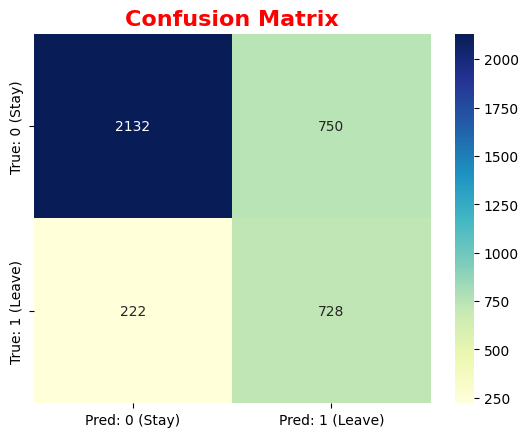

In [5]:
y_pred_scratch = model_scratch.predict(X_test, threshold=0.5)

acc = accuracy_score(y_test, y_pred_scratch)
prec = precision_score(y_test, y_pred_scratch)
rec = recall_score(y_test, y_pred_scratch)
f1 = f1_score(y_test, y_pred_scratch)

print(f"Evaluation Results")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

TP, TN, FP, FN = get_confusion_matrix(y_test, y_pred_scratch)
cm = np.array([[TN, FP], [FN, TP]])

sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", 
            xticklabels=['Pred: 0 (Stay)', 'Pred: 1 (Leave)'],
            yticklabels=['True: 0 (Stay)', 'True: 1 (Leave)'])
plt.title("Confusion Matrix", fontsize=16, fontweight='bold', color='red')
plt.show()

## From Scratch vs. From Scikit-learn


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss, accuracy_score

print("--- PERFORMANCE COMPARISON: FROM SCRATCH vs FROM SCIKIT-LEARN ---")

sklearn_model = LogisticRegression(penalty=None, class_weight='balanced', max_iter=2000, random_state=42)
sklearn_model.fit(X_train, y_train)

y_pred_sklearn = sklearn_model.predict(X_test)

f1_sklearn = f1_score(y_test, y_pred_sklearn)
f1_scratch = f1_score(y_test, y_pred_scratch)

print(f"\n[1] Scikit-learn Model:")
print(f"   F1-Score: {f1_sklearn:.4f}")

print(f"\n[2] My Numpy Model:")
print(f"   F1-Score: {f1_scratch:.4f}")

acc_diff = abs(f1_sklearn - f1_scratch)
if acc_diff < 0.05:
    print("\n✅ CONCLUSION: The from-scratch model performs WELL (Comparable to the standard library).")
else:
    print("\n⚠️ CONCLUSION: There is a significant discrepancy. Check the Learning Rate or number of iterations.")

--- PERFORMANCE COMPARISON: FROM SCRATCH vs FROM SCIKIT-LEARN ---

[1] Scikit-learn Model:
   F1-Score: 0.5973

[2] My Numpy Model:
   F1-Score: 0.5997

✅ CONCLUSION: The from-scratch model performs WELL (Comparable to the standard library).


## Cross Validation
- Stability Check
- Detect Overfitting
- Data Efficienct
- Hyperparameter Tuning

Fold 1/5: F1-Score = 0.5887
Fold 2/5: F1-Score = 0.6033
Fold 3/5: F1-Score = 0.5677
Fold 4/5: F1-Score = 0.6004
Fold 5/5: F1-Score = 0.5699
=> Average F1-Score: 0.5860


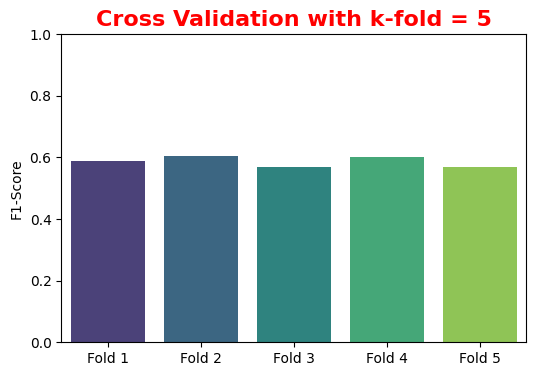

In [7]:
cv_scores = k_fold_cross_validation(X, y, k=5)

fold_names = [f"Fold {i+1}" for i in range(5)]

plt.figure(figsize=(6, 4))

sns.barplot(x=fold_names, y=cv_scores, hue=fold_names, palette="viridis", legend=False)

plt.ylim(0, 1.0)
plt.title("Cross Validation with k-fold = 5", fontsize=16, fontweight='bold', color='red')
plt.ylabel("F1-Score")
plt.show()

## Analysis & Insights


In [8]:
# Final fit
model_scratch = LogisticRegressionNumpy(learning_rate=0.1, n_iterations=2000, class_weight='balanced')

model_scratch.fit(X, y) 

FEATURE NAME              | WEIGHT     | IMPACT
--------------------------------------------------
size_missing              :  1.0044    🔴 LEAVE
High School               : -0.6649    🟢 STAY
city_development_index    : -0.6291    🟢 STAY
Primary School            : -0.4977    🟢 STAY
Unknown_edu               : -0.3714    🟢 STAY
Unknown_type              :  0.3495    🔴 LEAVE
pressure                  :  0.3005    🔴 LEAVE
Funded Startup            : -0.2867    🟢 STAY
STEM                      :  0.2721    🔴 LEAVE
no_enrollment             : -0.2293    🟢 STAY
last_new_job              :  0.2089    🔴 LEAVE
Male                      : -0.2015    🟢 STAY
Unknown_uni               : -0.1983    🟢 STAY
Public Sector             :  0.1960    🔴 LEAVE
Pvt Ltd                   : -0.1589    🟢 STAY


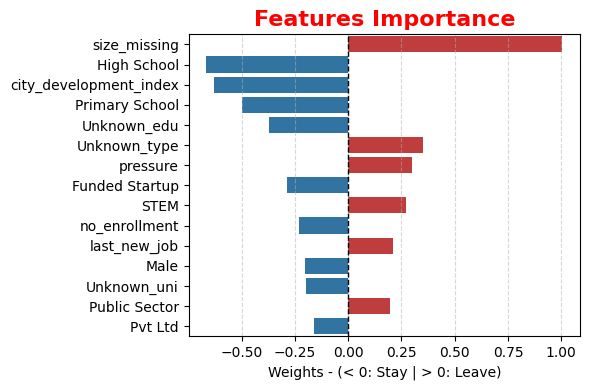

In [9]:
weights = model_scratch.weights

feature_names = [
    'city_development_index', 'training_hours', 
    'experience', 'company_size', 'last_new_job',
    'Male', 'Other_gender', 'Unknow_gender', 'Part time course', 'Unknown_uni', 'no_enrollment', 'STEM',
    'Funded Startup', 'NGO', 'Other_type', 'Public Sector', 'Pvt Ltd', 'Unknown_type', 'No relevent experience', 
    'High School', 'Masters', 'Phd', 'Primary School', 'Unknown_edu',
    'high_exp_low_cdi', 'is_job_hopper', 'growth', 'stability', 'pressure', 'training_intensity', 'size_missing'
]

indices = np.argsort(np.abs(weights[:len(feature_names)]))[::-1] 

top_features = []
top_weights = []

print(f"{'FEATURE NAME':<25} | {'WEIGHT':<10} | {'IMPACT'}")
print("-" * 50)

for i in range(15):
    idx = indices[i]
    name = feature_names[idx]
    w = weights[idx]
    
    top_features.append(name)
    top_weights.append(w)
    
    impact = "🔴 LEAVE" if w > 0 else "🟢 STAY"
    print(f"{name:<25} : {w:>7.4f}    {impact}")

plt.figure(figsize=(6, 4))

custom_colors = ['#d62728' if w > 0 else '#1f77b4' for w in top_weights]

sns.barplot(
    x=top_weights, 
    y=top_features, 
    hue=top_features,      
    palette=custom_colors, 
    legend=False           
)

plt.title("Features Importance", fontsize=16, fontweight='bold', color='red')
plt.xlabel("Weights - (< 0: Stay | > 0: Leave)")
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Conclusion**: After performing the processes from EDA, Preprocessing to building predictive models, I have drawn the following characteristics about each group:
- **No Change Job (Stay) Group**: 
    - Are personnel living in big cities (High CDI)
    - Working at funded startups
    - Have high school education or be a stable senior in the locality
- **Change Job (Leave) Group**:
    - STEM people, career changers   
    - Personnel currently working in the State sector or with unknown employment status